In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

### The goal is to use the Kolmogorov-Smirnov (KS) test to distinguish two data sets drawn from distributions that differ according to an adjustable perameter. 

The first distribution (MCI) will be drawn from a Poisson distribution (arbatrary choice; its already implemented for me in scipy), the second distribution (MCII) will be drawn from an identitical Poisson distribution, but will be ellement-wise summed with a gaussian with scalar x. The KS test should not be able to distinguish the two for x=0. We can draw a graph of p-score (the metric of intrest from the KS test) against the value of x to see when the two distributions become statistically distinct. 

I begin by drawing the unpreterbed Poisson distribution:

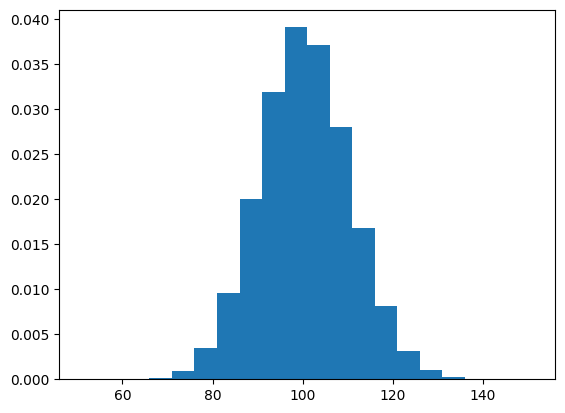

In [2]:
rng = np.random.default_rng()
plt.hist(stats.poisson.rvs(mu=100, size=1000000, random_state=rng), bins=20, density=True)
plt.show()

We can now take the trival case of compareing a distribution to itself useing the KS test. (Note this is the exact same data; not two sets drawn from the same distribution.)

In [3]:
# trivial example
sample1 = stats.poisson.rvs(mu=100, size=10, random_state=rng)
stats.kstest(sample1, sample1)

KstestResult(statistic=0.0, pvalue=1.0, statistic_location=88, statistic_sign=1)

Now, two sets drawn from identical distributions. Noteably, running this cell multiple times will yeald vastly diffrent results for p-value, but the statistic is below a reasonable threshhold (3 to 5 sigma, normally).

In [4]:
sample1 = stats.poisson.rvs(mu=100, size=10000, random_state=rng)
sample2 = stats.poisson.rvs(mu=100, size=10000, random_state=rng)
stats.kstest(sample1, sample2)

KstestResult(statistic=0.0088, pvalue=0.8335435086261689, statistic_location=98, statistic_sign=1)

Now, we can compare a Poisson distribution with a uniform distribution (again, an arbitrary choice, but already implemented for me). This time, we expect a low p-value.

In [5]:
sample1 = stats.poisson.rvs(mu=100, size=10000, random_state=rng)
sample2 = stats.uniform.rvs(size=1000, random_state=rng)
stats.kstest(sample1, sample2)

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=0.9976775692433602, statistic_sign=-1)

Now, we can compare two sets, both drawn from identically distributed uniform distributions to make sure the Poisson distribution isn't special in its behivior. Again, the p-value flucuates here, but the statistic is still below a reasonable threshhold. 

In [6]:
sample1 = stats.uniform.rvs(size=1000, random_state=rng)
sample2 = stats.uniform.rvs(size=10000, random_state=rng)
stats.kstest(sample1, sample2)

KstestResult(statistic=0.0234, pvalue=0.6945792581994921, statistic_location=0.10429976923598394, statistic_sign=-1)

Ok, now we have seen the test working in some simple cases, it's time to make the distributions we're intrested in. First, we will construct the MCII distribution by preterbing the MCI distribution with a gaussian with magnatude x (perameterized). I will draw a histogram of the preterbed and unpreterbed distributions, so we can get an idea of what the computer is tasked with distinguishing. 

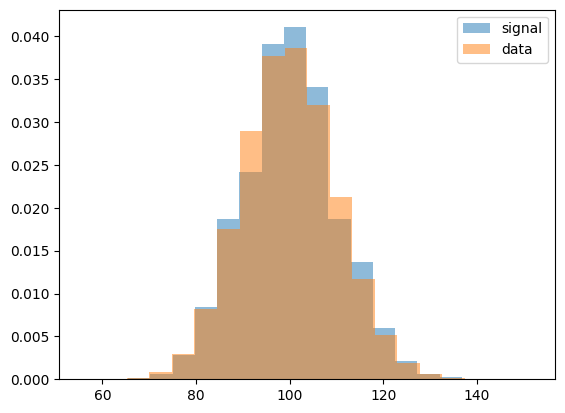

In [7]:
x = 10000
signal = stats.poisson.rvs(mu=100, size=1000000, random_state=rng)
noise = stats.norm.rvs(size=1000000)
plt.hist(signal, bins=20, density=True, alpha = 0.5, label='signal')
plt.hist(signal+noise, bins=20, density=True, alpha = 0.5, label='data')
plt.legend()
plt.show()

I can package the generation of the MCI & MCII, and compareing them using the KS test into a function parameterized on x (the magnatude of perterbation on MCII).

In [8]:
def ks_test(x, N=1000):
  signal = stats.poisson.rvs(mu=100, size=N, random_state=rng)
  noise = stats.norm.rvs(size=N)*x
  sample1 = signal + noise
  sample2 = stats.poisson.rvs(mu=100, size=N, random_state=rng)
  return stats.kstest(sample1, sample2)

Since the result of the KS test will be more stable with a larger data set, we must ask: what is a reasonable value for N?

To answer this question, we can take the maximum value if comparison of MCI & MCII over 100 trials at $N=10^5$. I played with N a bit, and this seems to be stable. We will soon have a more convincing demonstration that this is a reasonable value for N. 

In [9]:
max([ks_test(0, N=100000).statistic for i in range(100)])

0.006970000000000032

We can now draw a scatter plot of the 'statistic' (threshhold less than $3\sigma$) against values of x. 

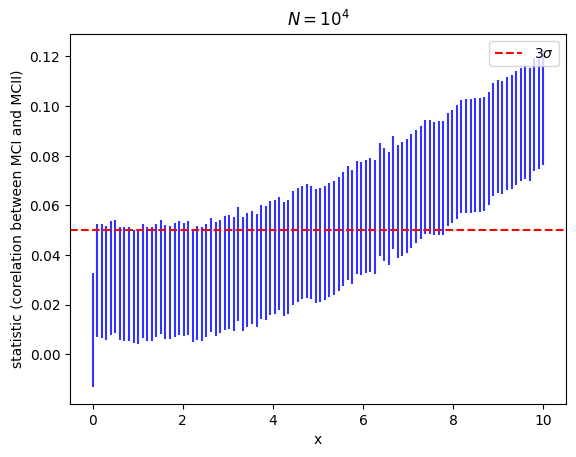

In [10]:
xs = np.linspace(0,10,100)
a = np.zeros(100)
b = np.zeros((100,10))
for i, x in enumerate(xs):
  a[i] = x
  for j in range(10):
    b[i, j] = ks_test(x, N=10000).statistic


plt.title("$N=10^4$")
plt.xlabel('x')
plt.ylabel('statistic (corelation between MCI and MCII)')
for i in range(100):
  plt.errorbar(a[i],b[i].mean(), yerr=b.std(), c='b', alpha=.8)
plt.axhline(y=0.05, label='3$\\sigma$ ', c='r', ls='--')
plt.legend()
plt.show()

We can see what happens if we run at an insufficiently small value of N. I will ditch the errorbars in favor of a regular scatter plot this time because error bars would be misleading. 

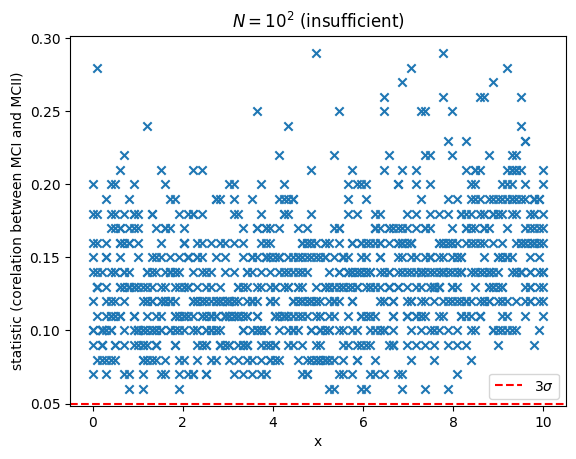

In [11]:
xs = np.linspace(0,10,100)
a = []
b = []
for x in xs:
  for i in range(10):
    a.append(x)
    b.append(ks_test(x, N=100).statistic)

plt.title("$N=10^2$ (insufficient)")
plt.xlabel('x')
plt.ylabel('statistic (corelation between MCI and MCII)')
plt.scatter(a,b,marker='x')
plt.axhline(y=0.05, label='3$\\sigma$ ', c='r', ls='--')
plt.legend()
plt.show()

As normally happens with any Monte Carlo simulation, we can reduce noise by throwing extra compute at the problem. I will increace N by an order of magnatude, but this now takes about a minute to run. 

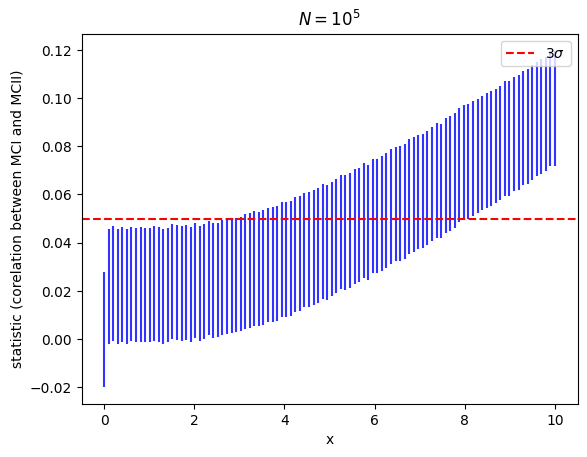

In [12]:
xs = np.linspace(0,10,100)
a = np.zeros(100)
b = np.zeros((100,10))
for i, x in enumerate(xs):
  a[i] = x
  for j in range(10):
    b[i, j] = ks_test(x, N=100000).statistic


plt.title("$N=10^5$")
plt.xlabel('x')
plt.ylabel('statistic (corelation between MCI and MCII)')
for i in range(100):
  plt.errorbar(a[i],b[i].mean(), yerr=b.std(), c='b', alpha=.8)
plt.axhline(y=0.05, label='3$\\sigma$ ', c='r', ls='--')
plt.legend()
plt.show()

Note that by increacing N, we are not reducing the error bars because each step still runs a fixed number of trials (10). However, we are increacing the stability, notice that the top and bottom of the error bars draw a smothe curve, whereas above when $N=10^4$, the curve is jagged. To reduce the error bars, we could run more than 10 trials for each value of x, but again, this would further increace compute time. 

The main point is that the test seems to work when compareing these, contrived distributions. The actual data is not important up to the fact that it is representative (which is why it is worth ensureing that it is stable).

In [22]:
#Draw hist of statistic for fixed value of perameters (hopefully Gaussian)
x = 8
statistics = np.array([ks_test(x, N=100000).statistic for i in range(1000)])

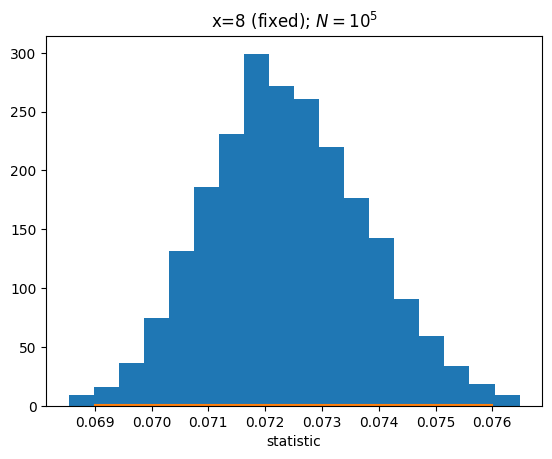

In [21]:
plt.title('x='+str(x)+' (fixed); $N=10^5$')
plt.xlabel('statistic')
plt.hist(statistics, density=True, bins=18)

def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
X=np.linspace(0.069, 0.076, 200)
plt.plot(X, gaussian(X, 1, np.mean(statistics), 1))

plt.show()